In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
np.random.seed(seed=1372022)
N=1000
base = 10
digits = base*(math.floor(np.log(N)/np.log(base))+1)

train_primes = list(primes_upto(N+1))
#train_composites = [i for i in range(1000) if i not in train_primes]
all_data = []
for k in range(N//len(train_primes)):
    all_data += [tuple((i, 1)) for i in range(1,N+1) if i in train_primes]
all_data += [tuple((i, 0)) for i in range(1,N+1) if i not in train_primes]

# all_data = [tuple((i, 1)) for i in range(1,N+1) if i in train_primes] + [tuple((i, 0)) for i in range(1,N+1) if i not in train_primes if np.random.uniform(0, 1)<len(train_primes)/N]

np.random.shuffle(all_data)

train_data = all_data[: math.floor(len(all_data)*0.8)]
test_data = set(all_data[math.floor(len(all_data)*0.8):])
test_data.difference(set(train_data))
test_data = list(test_data)

In [9]:
count = 0
for i in test_data:
    if i[1]:
        count += 1
print(count)
print(len(train_primes))
print(len(train_data))
print(len(test_data))

111
168
1337
275


In [10]:
counter_primes = 0
counter = 0
for i in all_data:
    if i[1]:
        counter_primes += 1
    else:
        counter += 1
print(counter_primes, counter)

print(train_data[:20])
print(len(train_data))
print(len(test_data))

840 832
[(593, 1), (933, 0), (229, 1), (772, 0), (835, 0), (461, 1), (214, 0), (643, 1), (822, 0), (563, 1), (39, 0), (839, 1), (947, 1), (727, 1), (522, 0), (389, 1), (181, 1), (36, 0), (991, 1), (353, 1)]
1337
275


In [11]:
#model
input = base*digits
output1 = 64
output2 = 128
output3 = 64
class MLP(nn.Module):
    def __init__(self,output1,output2, output3):
        super().__init__()
        self.step1 = nn.Linear(input, output1)
        self.step2 = nn.Linear(output1, output2)
        self.step3 = nn.Linear(output2, 1)

    def forward(self, x):
        
        x = self.step1(x)
        x = F.relu(x)
        x = self.step2(x)
        x = F.relu(x)
        #x = self.step3(x)
        #x = F.relu(x)
        x = self.step3(x)

        return x

In [12]:
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange

batch_size = 32
epochs = 500

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

## Training
# Instantiate model  
model = MLP(output1, output2, output3).to(device) 

# Loss and Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.BCEWithLogitsLoss()

tracking = True
if tracking:
  training_losses = []
  training_accuracies = []
  validation_accuracies = []


# Iterate through train set minibatchs 
for epoch in trange(epochs):  
    per_epoch_loss = 0
    correct = 0
    for numbers, labels in train_loader:
        x = numbers[:,None]
        x = x.to(device)
        x = encode(x, digits, base).float()
        labels = labels.double().to(device)[:,None]
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        y = model(x)
        loss = criterion(y, labels)
        if tracking:
          # Tracking loss
          per_epoch_loss += loss

          # Train accuracy tracking
          predictions = ((y>0)*1)
          correct += torch.sum((predictions == labels).float())

          # Validation accuracy tracking


        loss.backward()
        optimizer.step()
    if tracking:
      correct_test = 0
      with torch.no_grad():
              # Iterate through test set minibatchs 
              for numbers2, labels2 in val_loader:
                  numbers2 = numbers2.to(device)
                  labels2 = labels2.double().to(device)[:,None]
                  # Forward pass
                  x2 = numbers2[:,None]
                  x2 = encode(x2, digits, base).float()
                  y2 = model(x2)
                  predictions2 = ((y2>0)*1)[:,0]
                  correct_test += torch.sum((predictions2 == labels2).float())

      training_losses.append(per_epoch_loss/len(train_loader))
      training_accuracies.append(correct/len(train_data))
      validation_accuracies.append(correct_test/len(test_data))


/Users/zsiga007/Summer_2022/Summer-2022/utils.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


In [13]:
## Testing
correct = 0
total = len(test_data)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for numbers, labels in tqdm(test_loader):
        numbers = numbers.to(device)
        labels = labels.to(device)
        # Forward pass
        x = numbers[:,None]
        x = encode(x, digits, base).float()
        y = model(x)
        predictions = ((y>0)*1)[:, 0]
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.807272732257843


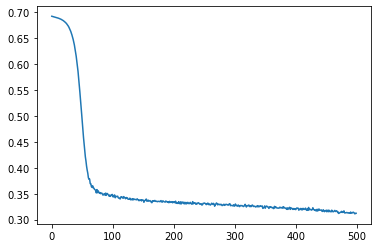

In [14]:

plt.plot([i.item() for i in training_losses])



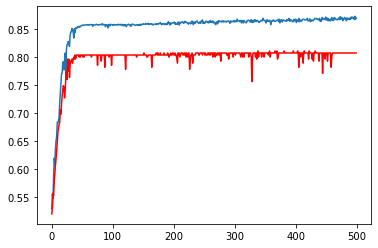

In [15]:
plt.plot([i.item() for i in training_accuracies])
plt.plot([i.item() for i in validation_accuracies], color = 'red')

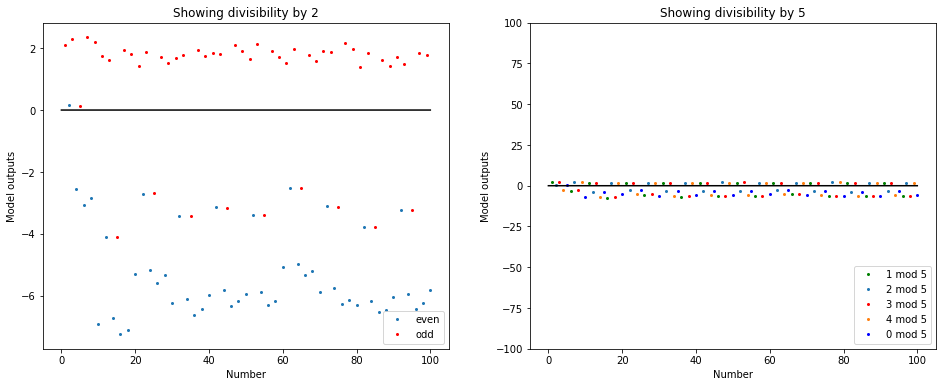

In [16]:
preds = [float(model(encode(torch.tensor([[i]]), digits, base).float())) for i in range(1,N+1)]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, N+1)[1:100:2], preds[1:100:2], 'o', markersize = 2, label="even")
plt.plot(range(1, N+1)[0:100:2], preds[0:100:2], 'ro', markersize = 2, label="odd")
#plt.ylim([-100, 100])
plt.plot(np.linspace(0, 100, 10000), np.zeros(10000), color='black')
plt.xlabel('Number')
plt.ylabel('Model outputs')
plt.title('Showing divisibility by 2')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
# plt.plot(range(1, N+1)[1:100:3], preds[1:100:3], 'ro', markersize = 2, label="0 mod 3")
plt.plot(range(1, N+1)[0:100:5], preds[0:100:5], 'go', markersize = 2, label="1 mod 5")
plt.plot(range(1, N+1)[1:100:5], preds[1:100:5], 'o', markersize = 2, label="2 mod 5")
plt.plot(range(1, N+1)[2:100:5], preds[2:100:5], 'ro', markersize = 2, label="3 mod 5")
plt.plot(range(1, N+1)[3:100:5], preds[3:100:5], 'o', markersize = 2, label="4 mod 5")
plt.plot(range(1, N+1)[4:100:5], preds[4:100:5], 'bo', markersize = 2, label="0 mod 5")
plt.ylim([-100, 100])
plt.plot(np.linspace(0, 100, 10000), np.zeros(10000), color='black')
plt.xlabel('Number')
plt.ylabel('Model outputs')
plt.title('Showing divisibility by 5')
plt.legend(loc='lower right')
plt.show()



In [89]:
print([index+1 for index, i in enumerate(preds) if i<0 if index%2==0][:20])

[1, 9, 15, 25, 33, 35, 39, 45, 49, 51, 55, 57, 65, 69, 75, 77, 81, 85, 87, 91]


In [90]:
print([index+1 for index, i in enumerate(preds) if i > 0 if not isPrime(index+1)])
print([index+1 for index, i in enumerate(preds) if i < 0 if isPrime(index+1)])

[21, 27, 63]
[]


In [91]:
## Testing
correct = 0
total = len(train_data)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for numbers, labels in tqdm(train_loader):
        numbers = numbers.to(device)
        labels = labels.to(device)
        # Forward pass
        x = numbers[:,None]
        x = encode(x, digits, base).float()
        y = model(x)

        predictions = ((y>0)*1)[:, 0]
        correct += torch.sum((predictions == labels).float())

print('Train accuracy: {}'.format(correct/total))


Train accuracy: 1.0


<ipython-input-4-5e5797f04886>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


In [92]:
x = torch.tensor([[30]])

x = encode(x, digits, base).float()
model(x)

<ipython-input-4-5e5797f04886>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


tensor([[-22.2568]], grad_fn=<AddmmBackward0>)